In [119]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
keras = tf.keras
from keras import Input, Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding, GRU, Bidirectional, BatchNormalization
from wordcloud import WordCloud
from collections import Counter
import csv
import math
import numpy as np
import pandas as pd
import re
import string
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from functools import lru_cache
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences


In [66]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to /home/deep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/deep/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/deep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [67]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
val_df = pd.read_csv("Valid.csv")
train_df.head(3)


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0


In [68]:
train_df.shape


(40000, 2)

In [69]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [70]:
train_df.duplicated().sum()


277

In [71]:
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()
val_df = val_df.drop_duplicates()
train_df.shape


(39723, 2)

In [72]:
VOCAB_SIZE = 10000
MAX_LENGTH = 200
OUTPUT_DIM = 128


In [73]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")


In [74]:
@lru_cache(maxsize=None)
def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub('\[.*?\]', "", text)
    text = re.sub('\\W', " ", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub('<.*?>+', "", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), "", text)
    text = re.sub('\n', "", text)
    text = re.sub('\w*\d\w*', "", text)

    return text


In [75]:
stop_words = set(stopwords.words('english'))
stop_words.add("br")

@lru_cache(maxsize=None)
def tokenize_and_lemmatize(text: str) -> [str]:
    tokens = word_tokenize(text)
    stemmed = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    return " ".join(stemmed)


In [76]:
train_df.iloc[:, 0] = train_df.iloc[:, 0].apply(lambda x: tokenize_and_lemmatize(preprocess(x)))
train_df.head(3)


,text,label
0,grew b watching loving thunderbird mate school...,0
1,put movie dvd player sat coke chip expectation...,0
2,people know particular time past like feel nee...,0


In [77]:
test_df.iloc[:, 0] = test_df.iloc[:, 0].apply(lambda x: tokenize_and_lemmatize(preprocess(x)))
test_df.head(3)


,text,label
0,always wrote series complete stink fest jim be...,0
1,watched dir steve purcell typical mary kate as...,0
2,movie poorly written directed fell asleep minu...,0


In [78]:
val_df.iloc[:, 0] = val_df.iloc[:, 0].apply(lambda x: tokenize_and_lemmatize(preprocess(x)))
val_df.head(3)


,text,label
0,year since sharon stone awarded viewer leg cro...,0
1,someone needed make car payment truly awful ma...,0
2,guideline state comment must contain minimum f...,0


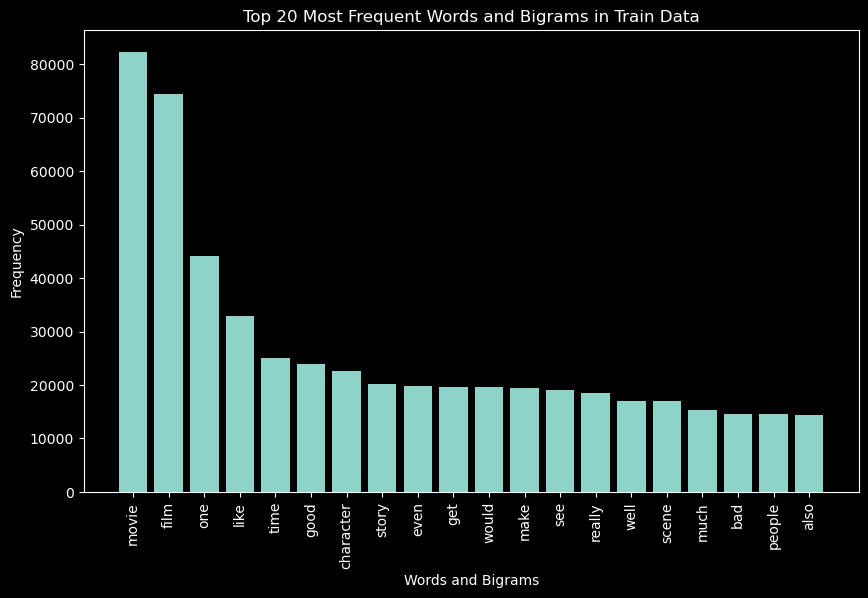

In [80]:
cv = CountVectorizer(ngram_range=(1, 2))
cv_train = cv.fit_transform(train_df.iloc[:, 0])

word_freq = pd.DataFrame(cv_train.sum(axis=0), columns=cv.get_feature_names_out()).T.sort_values(by=0, ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(word_freq.index[:20], word_freq.iloc[:20, 0])
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Words and Bigrams in Train Data')
plt.xlabel('Words and Bigrams')
plt.ylabel('Frequency')
plt.show()


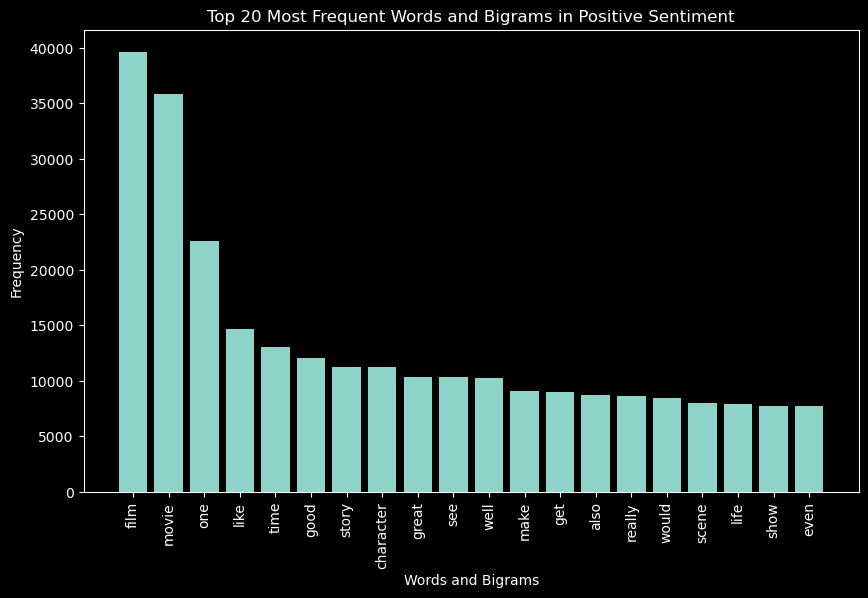

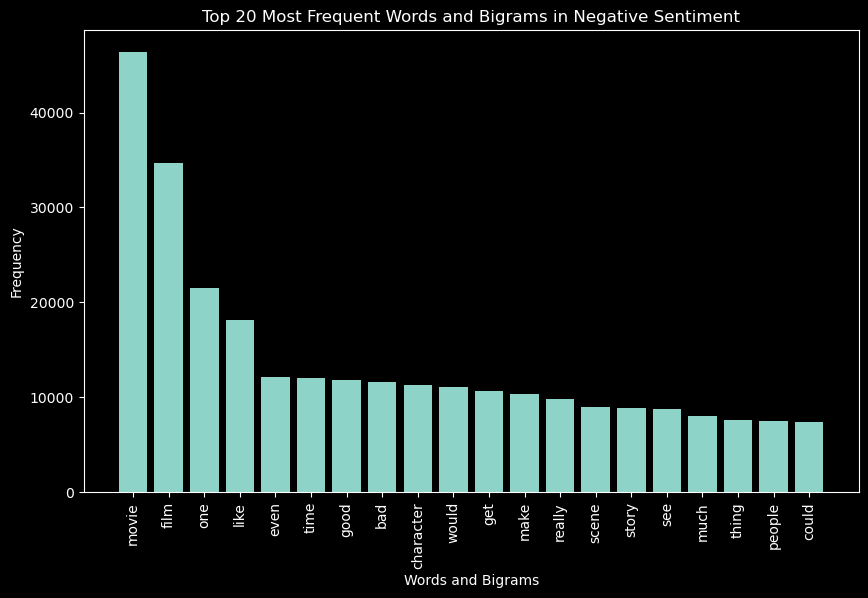

In [81]:
pos_df = train_df[train_df['label'] == 1]
neg_df = train_df[train_df['label'] == 0]

cv_pos = CountVectorizer(ngram_range=(1, 1))
cv_neg = CountVectorizer(ngram_range=(1, 1))
cv_train_pos = cv_pos.fit_transform(pos_df.iloc[:, 0])
cv_train_neg = cv_neg.fit_transform(neg_df.iloc[:, 0])

word_freq_pos = pd.DataFrame(cv_train_pos.sum(axis=0), columns=cv_pos.get_feature_names_out()).T.sort_values(by=0, ascending=False)
word_freq_neg = pd.DataFrame(cv_train_neg.sum(axis=0), columns=cv_neg.get_feature_names_out()).T.sort_values(by=0, ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(word_freq_pos.index[:20], word_freq_pos.iloc[:20, 0])
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Words and Bigrams in Positive Sentiment')
plt.xlabel('Words and Bigrams')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(word_freq_neg.index[:20], word_freq_neg.iloc[:20, 0])
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Words and Bigrams in Negative Sentiment')
plt.xlabel('Words and Bigrams')
plt.ylabel('Frequency')
plt.show()


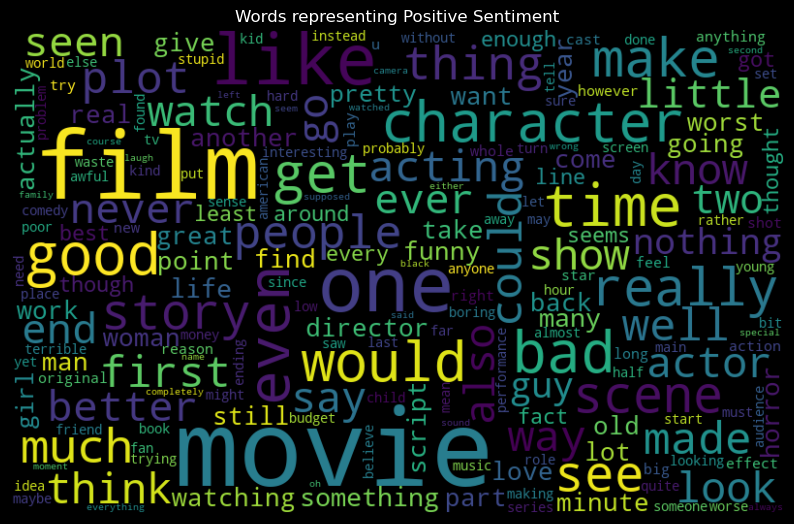

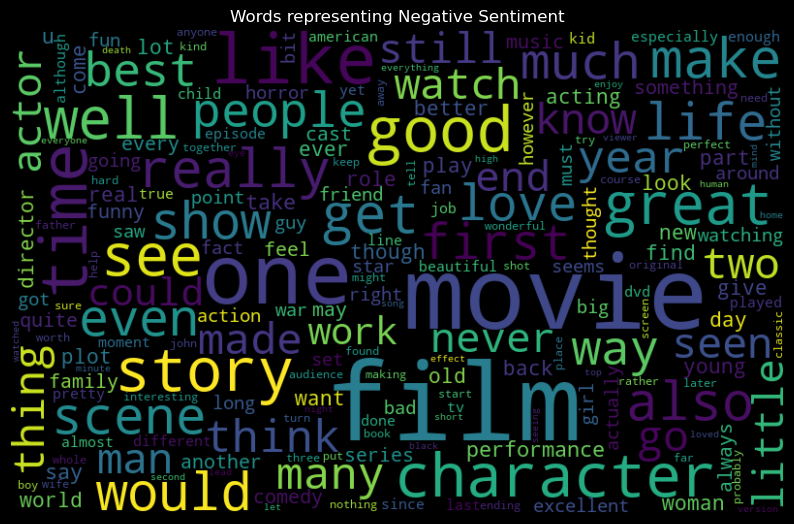

In [82]:
positive_text = train_df[train_df['label'] == 0]['text'].values
negative_text = train_df[train_df['label'] == 1]['text'].values

positive_freq = Counter(" ".join(positive_text).split())
negative_freq = Counter(" ".join(negative_text).split())

positive_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(positive_freq)
negative_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(negative_freq)

plt.figure(figsize=(10, 7))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Words representing Positive Sentiment')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Words representing Negative Sentiment')
plt.show()


In [87]:
tokenizer.fit_on_texts(train_df.iloc[:, 0])
train_sequences = tokenizer.texts_to_sequences(train_df.iloc[:, 0])
train_sequences = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')


In [88]:
tokenizer.fit_on_texts(test_df.iloc[:, 0])
test_sequences = tokenizer.texts_to_sequences(test_df.iloc[:, 0])
test_sequences = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')


In [89]:
tokenizer.fit_on_texts(val_df.iloc[:, 0])
val_sequences = tokenizer.texts_to_sequences(val_df.iloc[:, 0])
val_sequences = pad_sequences(val_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')


In [91]:
train_labels= pd.get_dummies(train_df['label']).values
test_labels= pd.get_dummies(test_df['label']).values
val_labels= pd.get_dummies(val_df['label']).values


In [101]:
lstm_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=OUTPUT_DIM, input_length=MAX_LENGTH),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(2, activation="sigmoid"),
])
lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
lstm_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 lstm_8 (LSTM)               (None, 200, 64)           49408     
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 lstm_8 (LSTM)               (None, 200, 64)           49408     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 2)                

In [104]:
lstm_hist = lstm_model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels))


1242/1242 [==============================] - 184s 145ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.5080


In [112]:
gru_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=OUTPUT_DIM, input_length=MAX_LENGTH),
    GRU(64, return_sequences=True),
    Dropout(0.5),
    GRU(64),
    Dropout(0.5),
    Dense(2, activation="sigmoid"),
])
gru_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
gru_model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 gru_2 (GRU)                 (None, 200, 64)           37248     
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 128)         

In [113]:
gru_hist = gru_model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels))


1242/1242 [==============================] - 166s 130ms/step - loss: 0.6943 - accuracy: 0.5040 - val_loss: 0.6921 - val_accuracy: 0.5130


In [124]:
bid_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=OUTPUT_DIM, input_length=MAX_LENGTH),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation="sigmoid"),
])
bid_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
bid_model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 200, 128)          1280000   
                                                                 
 bidirectional_18 (Bidirect  (None, 200, 128)          98816     
 ional)                                                          
                                                                 
 batch_normalization_5 (Bat  (None, 200, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 200, 128)          0         
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 200, 128)          1280000   
                                                     

In [125]:
bid_hist = bid_model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels))


1242/1242 [==============================] - 318s 245ms/step - loss: nan - accuracy: 0.4988 - val_loss: nan - val_accuracy: 0.4970


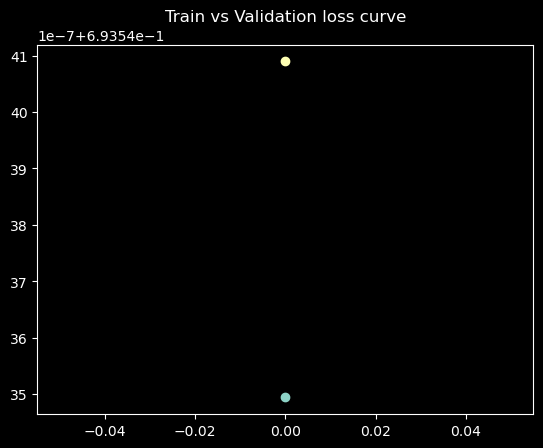

In [135]:
plt.title("LSTM Train vs Validation loss curve")
plt.scatter(0, lstm_hist.history["loss"])
plt.scatter(0, lstm_hist.history["val_loss"])


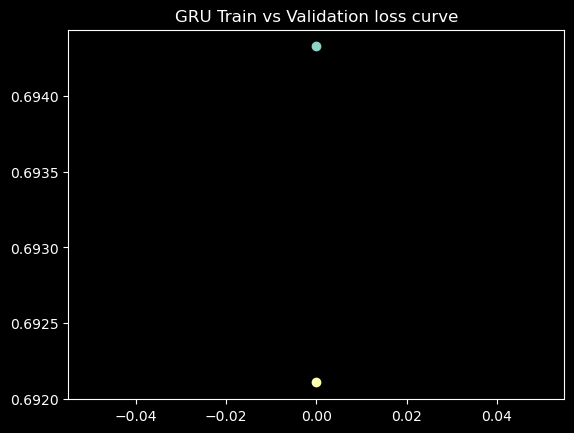

In [136]:
plt.title("GRU Train vs Validation loss curve")
plt.scatter(0, gru_hist.history["loss"])
plt.scatter(0, gru_hist.history["val_loss"])
